In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
    
from keras.models import Sequential, Model
from keras.regularizers import l2
from keras.layers import Input, Flatten, Dense, Dropout, Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
csv_file = 'GermanCreditRisk.csv'

dataframe = pd.read_csv(csv_file)
# Replace NaN with most common value
dataframe = dataframe.fillna(dataframe.mode().iloc[0])

In [3]:
dataframe['target'] = np.where(dataframe['Risk']=="bad", 1, 0)

dataframe.head()

# Oversample the minority class
num_samples = dataframe['target'].value_counts().max()
df_majority = dataframe[dataframe.target == 0]
df_minority = dataframe[dataframe.target == 1]
df_minority_upsampled = df_minority.sample(num_samples, replace=True)
dataframe = pd.concat([df_majority, df_minority_upsampled])

# Drop unused columns.
dataframe = dataframe.drop(columns=['col', 'Risk'])

# Create new column called CD which is Credit Amount / Duration
dataframe['CD'] = dataframe['CreditAmount'] / dataframe['Duration']

dataframe.head()

,Age,Sex,Job,Housing,SavingAccounts,CheckingAccount,CreditAmount,Duration,Purpose,target,CD
0,67,male,2,own,little,little,1169,6,radio/TV,0,194.833333
2,49,male,1,own,little,little,2096,12,education,0,174.666667
3,45,male,2,free,little,little,7882,42,furniture/equipment,0,187.666667
5,35,male,1,free,little,little,9055,36,education,0,251.527778
6,53,male,2,own,quite rich,little,2835,24,furniture/equipment,0,118.125000


In [4]:
train, val = train_test_split(dataframe, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')

1120 train examples
280 validation examples


In [5]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)

for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))

Every feature: ['Age', 'Sex', 'Job', 'Housing', 'SavingAccounts', 'CheckingAccount', 'CreditAmount', 'Duration', 'Purpose', 'CD']


In [6]:
# Define the feature columns
feature_columns = []

age = tf.feature_column.numeric_column("Age")
age_buckets = tf.feature_column.bucketized_column(age, boundaries=[20, 50, 80])
print(age_buckets)
feature_columns.append(age_buckets)

sex = tf.feature_column.categorical_column_with_vocabulary_list(
"Sex", ["male", "female"])
sex = tf.feature_column.indicator_column(sex)
feature_columns.append(sex)

# job is a number, but we want to treat it as a categorical feature
job = tf.feature_column.categorical_column_with_identity("Job", num_buckets=4) 
job = tf.feature_column.indicator_column(job)
feature_columns.append(job)

housing = tf.feature_column.categorical_column_with_vocabulary_list(
"Housing", ["own", "rent", "free"])
housing = tf.feature_column.indicator_column(housing)
feature_columns.append(housing)

saving_accounts = tf.feature_column.categorical_column_with_vocabulary_list(
"SavingAccounts", ["little", "moderate", "quite rich", "rich", "NA"])
saving_accounts = tf.feature_column.indicator_column(saving_accounts)

feature_columns.append(saving_accounts)

checking_account = tf.feature_column.categorical_column_with_vocabulary_list(
"CheckingAccount", ["little", "moderate", "rich", "NA"])
checking_account = tf.feature_column.indicator_column(checking_account)
feature_columns.append(checking_account)

# credit_amount is a number, but we want to treat it as a categorical feature
credit_amount = tf.feature_column.categorical_column_with_identity("CreditAmount", num_buckets=5)
credit_amount = tf.feature_column.indicator_column(credit_amount)
feature_columns.append(credit_amount)

# credit_amount = tf.feature_column.numeric_column("CreditAmount")
# feature_columns.append(credit_amount)

# duration is a number, but we want to treat it as a categorical feature, buckets should be 12, 24, 36, 48, 60, 72
duration = tf.feature_column.categorical_column_with_identity("Duration", num_buckets=6)
duration = tf.feature_column.indicator_column(duration)

# duration = tf.feature_column.numeric_column("Duration")
# feature_columns.append(duration)

purpose = tf.feature_column.categorical_column_with_vocabulary_list(
"Purpose", ["radio/TV", "education", "furniture/equipment", "car", "business", "domestic appliances", "repairs", "vacation/others"])
purpose = tf.feature_column.indicator_column(purpose)
feature_columns.append(purpose)

# Verify the feature columns
for feature in feature_columns:
  print(feature)
  print("\n")

BucketizedColumn(source_column=NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(20, 50, 80))
BucketizedColumn(source_column=NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(20, 50, 80))


IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0))


IndicatorColumn(categorical_column=IdentityCategoricalColumn(key='Job', number_buckets=4, default_value=None))


IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Housing', vocabulary_list=('own', 'rent', 'free'), dtype=tf.string, default_value=-1, num_oov_buckets=0))


IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='SavingAccounts', vocabulary_list=('little', 'moderate', 'quite rich', 'rich', 'NA'), dtype=tf.string, default_value=-1, num_oov_buckets=0))


IndicatorColumn(

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.DenseFeatures(feature_columns),
    # This is CSV data
    # Convolutions expect 3D data, so we need to reshape the data
    # Data shape is currently [33] (1D)
    # We need to reshape it to [33, 1, 1] (3D)
    tf.keras.layers.Reshape(target_shape=(35, 1, 1)),
    tf.keras.layers.Conv2D(filters=8, kernel_size=(2,2), strides=(1,1), padding='same', activation='LeakyReLU'),
    tf.keras.layers.Dense(16, activation="LeakyReLU"),
    tf.keras.layers.Dense(8, activation='LeakyReLU'),
    tf.keras.layers.Dense(8, activation='LeakyReLU'),
    # Data shape is currently [26, 1, 32] (3D)
    # Final Dense layer expects 1D data, so we need to flatten the data
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall()]
)

In [8]:
filepath = r"C:\Users\karan\Programming\Python\Credit-Risk-Classifier\Final Model\weights-{epoch:02d}.h5"
checkpoint = ModelCheckpoint(filepath, save_weights_only=False, save_freq='epoch', verbose=1)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[callback, checkpoint]
)

Epoch 1/50
222/224 [============================>.] - ETA: 0s - loss: 0.6925 - accuracy: 0.5135 - recall: 0.5519WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor. Received: inputs={'Age': <tf.Tensor 'IteratorGetNext:0' shape=(None,) dtype=int64>, 'Sex': <tf.Tensor 'IteratorGetNext:9' shape=(None,) dtype=string>, 'Job': <tf.Tensor 'IteratorGetNext:6' shape=(None,) dtype=int64>, 'Housing': <tf.Tensor 'IteratorGetNext:5' shape=(None,) dtype=string>, 'SavingAccounts': <tf.Tensor 'IteratorGetNext:8' shape=(None,) dtype=string>, 'CheckingAccount': <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=string>, 'CreditAmount': <tf.Tensor 'IteratorGetNext:3' shape=(None,) dtype=int64>, 'Duration': <tf.Tensor 'IteratorGetNext:4' shape=(None,) dtype=int64>, 'Purpose': <tf.Tensor 'IteratorGetNext:7' shape=(None,) dtype=string>, 'CD': <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=float64>}. Consider rewriting this model with the Functional API.

Epoch 1: savin

dict_keys(['loss', 'accuracy', 'recall', 'val_loss', 'val_accuracy', 'val_recall'])


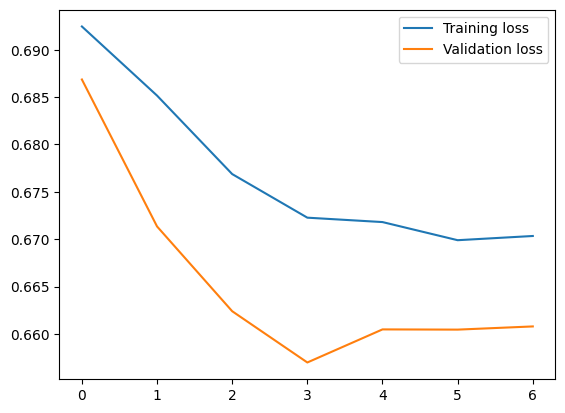

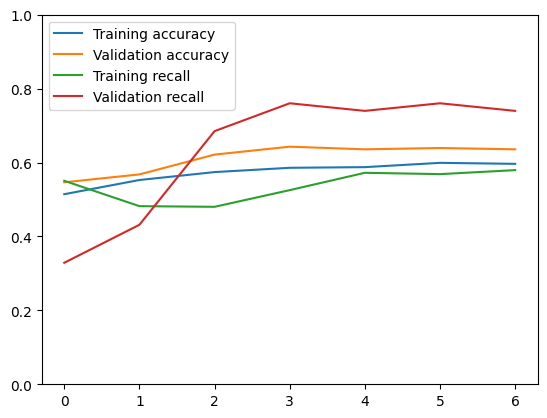

1/1 [==============================] - 0s 19ms/step
280
[[ 70  64]
 [ 38 108]]


In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

print(history.history.keys())

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# Show accuracy vs recall
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.plot(history.history['recall'], label='Training recall')
plt.plot(history.history['val_recall'], label='Validation recall')

plt.ylim([0, 1])
plt.legend()
plt.show()

# Create a confusion matrix
predictions = []
actual = []
for feature_batch, label_batch in val_ds:
    predictions.extend(model.predict(feature_batch))
    actual.extend(label_batch.numpy())

predictions = [1 if x > 0.5 else 0 for x in predictions]
actual = [1 if x > 0.5 else 0 for x in actual]

print(len(predictions))

cm = confusion_matrix(actual, predictions)
print(cm)